In [27]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


In [28]:
# Get Dataset
wine_quality = fetch_ucirepo(id=186)

# Load data into pd dataframe
df = wine_quality.data.original
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [29]:
X = wine_quality.data.features 
y = wine_quality.data.targets 

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y.values.ravel(),test_size=0.2,random_state=42)

### Decision Trees

/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'rf__criterion': 'entropy', 'rf__max_depth': 20, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
Best cross-validation score:  0.6417290940815843
Test set accuracy:  0.6623076923076923
              precision    recall  f1-score   support

           3      0.250     0.167     0.200         6
           4      0.333     0.349     0.341        43
           5      0.677     0.741     0.708       402
           6      0.698     0.667     0.682       597
           7      0.626     0.614     0.620       215
           8      0.567     0.472     0.515        36
           9      0.000     0.000     0.000         1

    accuracy                          0.662      1300
   macro avg      0.450     0.430     0.438      1300
weighted avg      0.661     0.662     0.661      1300



/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

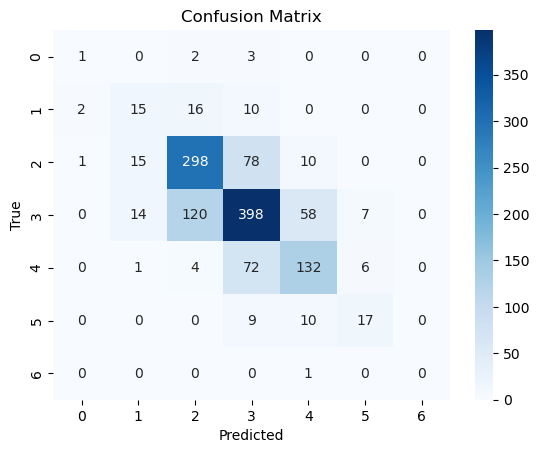

In [38]:
from imblearn.pipeline import Pipeline
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42, k_neighbors=2)),
    ('rf', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# Define the parameter grid
param_grid = {
    'rf__n_estimators': [10, 50, 100, 200, 400],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_features': ['log2', 'sqrt'],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
}

# Set up GridSearchCV
rf_grid = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
)

rf_grid.fit(X_train, y_train)

print("Best parameters found: ", rf_grid.best_params_)
print("Best cross-validation score: ", rf_grid.best_score_)

# Make predictions
y_pred = rf_grid.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)

# Classification report
print(classification_report(y_test, y_pred, digits=3))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


              precision    recall  f1-score   support

           3       0.25      0.17      0.20         6
           4       0.33      0.35      0.34        43
           5       0.68      0.74      0.71       402
           6       0.70      0.67      0.68       597
           7       0.63      0.61      0.62       215
           8       0.57      0.47      0.52        36
           9       0.00      0.00      0.00         1

    accuracy                           0.66      1300
   macro avg       0.45      0.43      0.44      1300
weighted avg       0.66      0.66      0.66      1300



/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

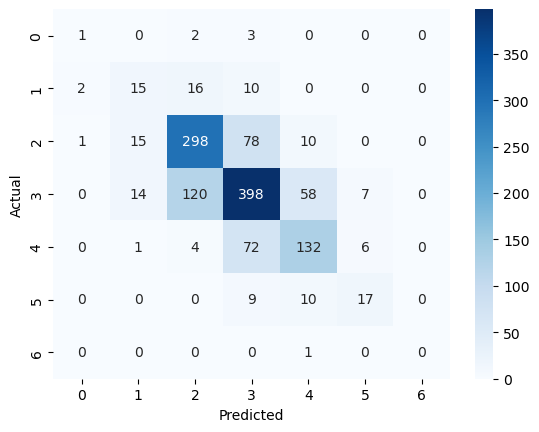

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters found:  {'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 100}
Best cross-validation score:  0.6372863786389263
Test set accuracy:  0.6584615384615384
              precision    recall  f1-score   support

           3      0.250     0.167     0.200         6
           4      0.357     0.349     0.353        43
           5      0.664     0.731     0.696       402
           6      0.706     0.665     0.685       597
           7      0.607     0.619     0.613       215
           8      0.533     0.444     0.485        36
           9      0.000     0.000     0.000         1

    accuracy                          0.658      1300
   macro avg      0.445     0.425     0.433      1300
weighted avg      0.658     0.658     0.657      1300

              precision    recall  f1-score   support

           3       0.25      0.17      0.20         6
           4       0.36  

/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

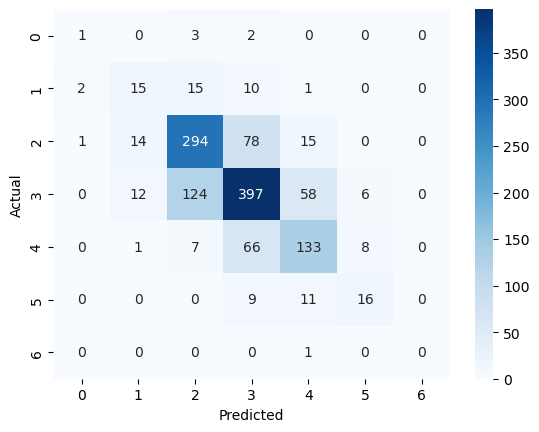

In [43]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=cv,  
    n_jobs=-1,
)

rf_grid.fit(X_train, y_train)
print("Best parameters found: ", rf_grid.best_params_)
print("Best cross-validation score: ", rf_grid.best_score_)
# Make predictions
y_pred = rf_grid.predict(X_test)
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", accuracy)
# Classification report
print(classification_report(y_test, y_pred, digits=3))
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SVM

In [75]:
from sklearn.svm import SVC
import os
import pickle
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# Define base parameter grid
param_grid = {
    'svc__C': [.1, 1, 10, 100],
    'svc__gamma': [.001, .01, .1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf'],
    'svc__class_weight': [None, 'balanced'],
}

# Define two pipelines: with and without PCA
pipelines = {
    'without_pca': Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(cache_size=32768))
    ]),
    'with_pca': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('svc', SVC(cache_size=32768))
    ])
}

results = {}

# Loop over both pipelines
for name, pipeline in pipelines.items():
    model_filename = f'grid_search_{name}.pkl'
    
    if os.path.exists(model_filename):
        with open(model_filename, 'rb') as file:
            grid = pickle.load(file)
        print(f"Loaded cached grid for: {name}")
    else:
        print(f"Running grid search for: {name}...")
        grid = GridSearchCV(pipeline, param_grid, cv=4, verbose=2, n_jobs=-1)
        grid.fit(X_train, y_train)
        with open(model_filename, 'wb') as file:
            pickle.dump(grid, file)

    # Evaluate best model
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    results[name] = {
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_,
        'test_score': test_acc
    }

# Display side-by-side comparison
comparison_df = pd.DataFrame(results).T
print("\nSVM with and without PCA Comparison:")
print(comparison_df)

Loaded cached grid for: without_pca
Loaded cached grid for: with_pca

SVM with and without PCA Comparison:
                                                   best_params  cv_score  \
without_pca  {'svc__C': 100, 'svc__class_weight': None, 'sv...  0.623053   
with_pca     {'svc__C': 10, 'svc__class_weight': None, 'svc...  0.620168   

            test_score  
without_pca   0.633846  
with_pca      0.634615  


Test set accuracy (without PCA): 0.6338461538461538
              precision    recall  f1-score   support

           3      0.000     0.000     0.000         6
           4      0.364     0.186     0.246        43
           5      0.616     0.629     0.622       402
           6      0.634     0.732     0.680       597
           7      0.704     0.530     0.605       215
           8      0.750     0.333     0.462        36
           9      0.000     0.000     0.000         1

    accuracy                          0.634      1300
   macro avg      0.438     0.344     0.373      1300
weighted avg      0.631     0.634     0.626      1300



/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/adrian/miniconda3/envs/ISLP/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

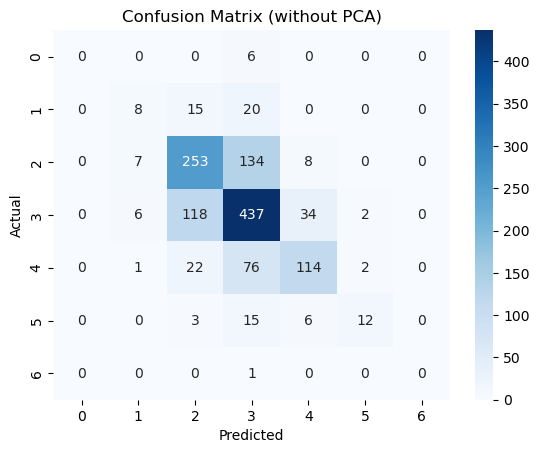

In [76]:
# Get the best model from the without_pca pipeline
best_model_without_pca = pipelines['without_pca'].set_params(**results['without_pca']['best_params'])

# Fit the model on the training data
best_model_without_pca.fit(X_train, y_train)

# Make predictions
y_pred_without_pca = best_model_without_pca.predict(X_test)

# Evaluate the model
accuracy_without_pca = accuracy_score(y_test, y_pred_without_pca)
print("Test set accuracy (without PCA):", accuracy_without_pca)

# Classification report
print(classification_report(y_test, y_pred_without_pca, digits=3))

# Confusion matrix
cm_without_pca = confusion_matrix(y_test, y_pred_without_pca)
sns.heatmap(cm_without_pca, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (without PCA)")
plt.show()

### Neural Network